In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import backend as K

import sys
import pandas as pd

from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator


import threading
import random
#import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [3]:
%matplotlib inline

In [4]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.8 MB/s 


In [5]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [6]:



IMAGES_PATH = '/content/drive/MyDrive/fire_dataset/images/'
MASKS_PATH = '/content/drive/MyDrive/fire_dataset/masks/'

OUTPUT_DIR = '/content/drive/MyDrive/fire_dataset/train_output/'

images = [f for f in os.listdir(IMAGES_PATH)]
masks = [f for f in os.listdir(MASKS_PATH)]


In [7]:
len(images)

995

In [8]:
len(masks)

995

## Displaying images and masks

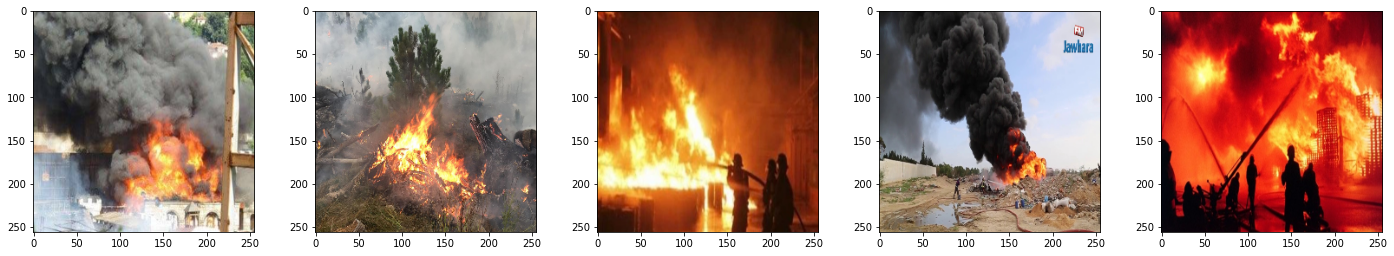

In [9]:

fig = plt.figure(figsize=(20,20)) 
n=0
for i in range(20,25):
    plt.subplot(1,5,n+1)
    n=n+1
    img=cv2.imread(IMAGES_PATH + images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    plt.imshow(img)
    fig.tight_layout(pad=3.0)
    
plt.show()

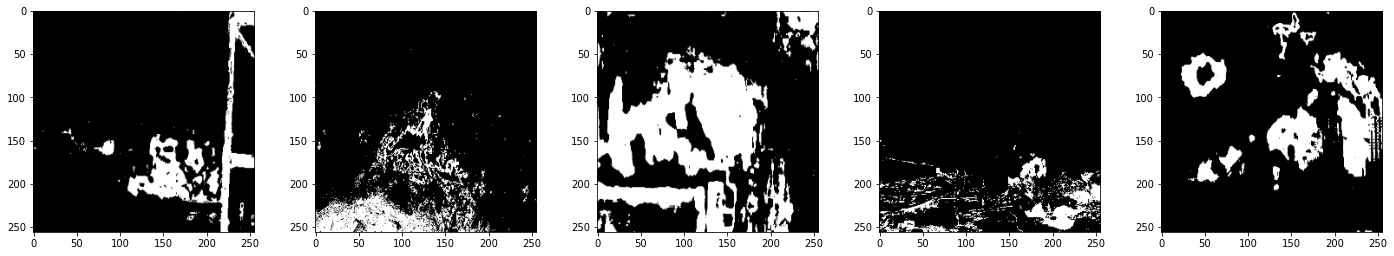

In [10]:
fig = plt.figure(figsize=(20,20))
n=0
for i in range(20,25):
    plt.subplot(1,5,n+1)
    n=n+1
    img=cv2.imread(MASKS_PATH + masks[i])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(256,256))
    plt.imshow(img)
    fig.tight_layout(pad=3.0)
plt.show()

## Data Preprocessing

In [11]:
SIZE =128
img_dataset = []
images = os.listdir(IMAGES_PATH)
for i,image_name in enumerate(images):
  if (image_name.split('.')[2]=='png'):
    image = cv2.imread(IMAGES_PATH + image_name)
    image = cv2.resize(image,(SIZE,SIZE))
    img_dataset.append(np.array(image))

In [12]:
print(len(img_dataset))
print(img_dataset[0].shape)

995
(128, 128, 3)


In [13]:
masks = os.listdir(MASKS_PATH)
mask_dataset = []
for i,mask_name in enumerate(masks):
  if (mask_name.split('.')[2]=='png'):
    mask =cv2.imread(MASKS_PATH + mask_name)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,(SIZE,SIZE))
    mask_dataset.append(np.array(mask))

In [14]:
print(len(mask_dataset))
print(mask_dataset[0].shape)

995
(128, 128)


In [15]:
img_dataset = np.array(img_dataset)
img_dataset = img_dataset/255.

mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset/255.

In [16]:
x_train , x_test , y_train , y_test = train_test_split(img_dataset , mask_dataset ,test_size = 0.15, random_state = 0)

# Model Building

In [17]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_height=128, input_width=128, n_filters = 16, dropout = 0.1, batchnorm = True):
    input_img = Input(shape=(input_height,input_width, 3))

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
model=get_unet()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss
model.compile(optimizer='Adam', 
              loss=sm.losses.jaccard_loss,
              metrics=[sm.metrics.iou_score])

# model.compile(optimizer='Adam', 
#               loss='categorical_crossentropy',
#               metrics=[IOUScore])

In [21]:
history = model.fit(x_train,
                    y_train,
                    batch_size = 32,
                    epochs = 100,
                    verbose = 1,
                    validation_data = (x_test , y_test))

Epoch 1/100
27/27 [==============================] - 20s 170ms/step - loss: 0.6846 - iou_score: 0.3155 - val_loss: 0.6970 - val_iou_score: 0.3042
Epoch 2/100
27/27 [==============================] - 3s 93ms/step - loss: 0.6286 - iou_score: 0.3697 - val_loss: 0.7236 - val_iou_score: 0.2768
Epoch 3/100
27/27 [==============================] - 3s 94ms/step - loss: 0.6076 - iou_score: 0.3934 - val_loss: 0.6754 - val_iou_score: 0.3258
Epoch 4/100
27/27 [==============================] - 3s 94ms/step - loss: 0.5900 - iou_score: 0.4102 - val_loss: 0.6850 - val_iou_score: 0.3159
Epoch 5/100
27/27 [==============================] - 3s 95ms/step - loss: 0.5769 - iou_score: 0.4253 - val_loss: 0.6475 - val_iou_score: 0.3544
Epoch 6/100
27/27 [==============================] - 3s 94ms/step - loss: 0.5595 - iou_score: 0.4429 - val_loss: 0.6137 - val_iou_score: 0.3883
Epoch 7/100
27/27 [==============================] - 3s 95ms/step - loss: 0.5496 - iou_score: 0.4486 - val_loss: 0.6103 - val_iou_scor

In [ ]:
# FINAL_WEIGHTS_OUTPUT = 'model_final_weights_final_18_April.h5'
# OUTPUT_DIR='/content/drive/MyDrive/fire_dataset/train_output'
# model_weights_output = os.path.join(OUTPUT_DIR, FINAL_WEIGHTS_OUTPUT)
# model.save_weights(model_weights_output)

# Testing

In [ ]:
# WEIGHTS_FILE='/content/drive/MyDrive/fire_dataset/train_output/model_final_weights_29th_mar_2.h5'
# model.load_weights(WEIGHTS_FILE)

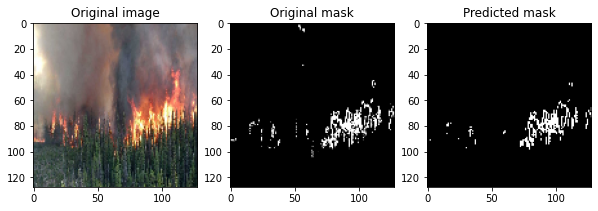

In [ ]:
SIZE=128
img1 = '/content/drive/MyDrive/fire_dataset/images/fire.26.png'
mask1 = '/content/drive/MyDrive/fire_dataset/masks2/fire.26_m.png'

img1 = cv2.imread(img1)
img1 = cv2.resize(img1,(SIZE,SIZE))
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
image = np.array(img1).reshape(1,SIZE,SIZE,3)
image = image/255.
pred = model.predict(image)

pred = (pred[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Original image')
plt.imshow(img2)

plt.subplot(132)
mask1 = cv2.imread(mask1)
mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
mask1 = cv2.resize(mask1,(SIZE,SIZE))/255.0
plt.title('Original mask')
plt.imshow(mask1,cmap='gray')

plt.subplot(133)#
pred=pred.reshape(SIZE,SIZE,1)
pred1=tf.keras.utils.array_to_img(pred)
plt.imshow(pred1,cmap='gray')
plt.title('Predicted mask')
#plt.show()
#plt.savefig('fig1.png')


Text(0.5, 1.0, 'Predicted mask')

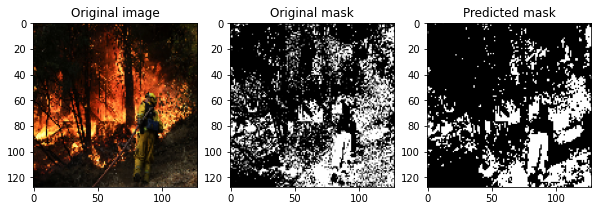

In [22]:
img1 = '/content/drive/MyDrive/fire_dataset/images/fire.463.png'
mask1 = '/content/drive/MyDrive/fire_dataset/masks/fire.463_m.png'

img1 = cv2.imread(img1)
img1 = cv2.resize(img1,(SIZE,SIZE))
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
image = np.array(img1).reshape(1,SIZE,SIZE,3)
image = image/255.
pred = model.predict(image)

pred = (pred[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Original image')
plt.imshow(img2)

plt.subplot(132)
mask1 = cv2.imread(mask1)
mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
mask1 = cv2.resize(mask1,(SIZE,SIZE))/255.0
plt.title('Original mask')
plt.imshow(mask1,cmap='gray')

plt.subplot(133)#
pred=pred.reshape(SIZE,SIZE,1)
pred1=tf.keras.utils.array_to_img(pred)
plt.imshow(pred1,cmap='gray')
plt.title('Predicted mask')